# Phishing Email Detector

## Setup

In [1]:
from pathlib import Path
import re
import os
import random
import math
from collections import Counter


import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urlextract import URLExtract
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler

from utils import EmailDataset, tokenize, build_vocab, preprocess_text

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Config
DATA_PROCESSED = Path("data/preprocessed")  # path
FILEPATH_DATA_PREPROCESSED = DATA_PROCESSED / "preprocessed_data.npz"  # filename
DATA_ALREADY_PREPROCESSED = True  # whether the data is already preprocessed

MAX_VOCAB = 40000
MAX_LEN = 256
EMBED_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 6
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

/home/enrico/Desktop/PED/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


[nltk_data] Downloading package punkt_tab to /home/enrico/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load the Dataset

Looking for dataset at: data/preprocessed/preprocessed_data.npz
Keys in file: ['texts', 'tokens', 'labels', 'urls', 'num_feats']
Data loaded successfully.
Number of samples: 18650
Feature shapes - texts: (18650,), tokens: (18650,), labels: (18650,), urls: (18650,), num_feats: (18650, 6)

📊 DataFrame preview:
                                                text  \
0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1  the other side of * galicismos * * galicismo *...   
2  re : equistar deal tickets are you still avail...   
3  hello i am your hot lil horny toy. i am the on...   
4  software at incredibly low prices ( 86 % lower...   

                                              tokens  label  \
0  [re, :, 6, ., 1100, ,, disc, :, uniformitarian...      0   
1  [the, other, side, of, *, galicismos, *, *, ga...      0   
2  [re, :, equistar, deal, tickets, are, you, sti...      0   
3  [hello, i, am, your, hot, lil, horny, toy, ., ...      1   
4  [software, at, incredibly, low, pri

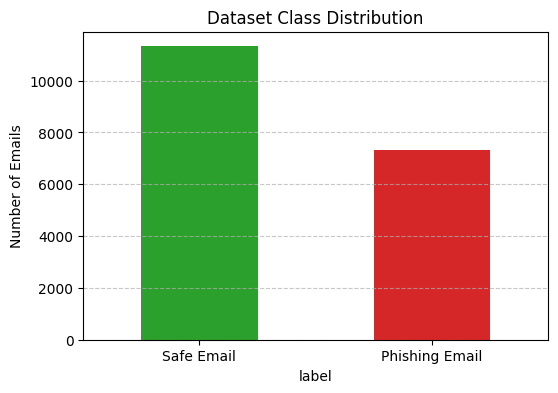

In [2]:
print(f"Looking for dataset at: {FILEPATH_DATA_PREPROCESSED}")

assert os.path.exists(
    FILEPATH_DATA_PREPROCESSED
), f"Dataset not found: {FILEPATH_DATA_PREPROCESSED}"
data = np.load(FILEPATH_DATA_PREPROCESSED, allow_pickle=True)

print("Keys in file:", list(data.keys()))

texts = data["texts"]
tokens = data["tokens"]
labels = data["labels"]
urls = data["urls"]
num_feats = data["num_feats"]

print("Data loaded successfully.")
print(f"Number of samples: {len(texts)}")
print(
    f"Feature shapes - texts: {texts.shape}, tokens: {tokens.shape}, labels: {labels.shape}, urls: {urls.shape}, num_feats: {num_feats.shape}"
)


df = pd.DataFrame({"text": texts, "tokens": tokens, "label": labels, "urls": urls})

# --- Rebuild DataFrame for analysis ---
num_feat_cols = ["n_urls", "n_upper", "n_exclaim", "n_special", "length", "has_login_words"]

# Add numeric feature columns
num_feats_df = pd.DataFrame(num_feats, columns=num_feat_cols)
df = pd.concat([df, num_feats_df], axis=1)

# --- Preview ---
print("\n📊 DataFrame preview:")
print(df.head())

# --- Dataset size and label distribution ---
print("\nDataset size:", len(df))
print("Label distribution:\n", df["label"].value_counts())

# --- Class distribution plot ---
plt.figure(figsize=(6, 4))
df["label"].value_counts().plot(kind="bar", color=["#2ca02c", "#d62728"])
plt.xticks(ticks=[0, 1], labels=["Safe Email", "Phishing Email"], rotation=0)
plt.title("Dataset Class Distribution")
plt.ylabel("Number of Emails")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Model

In [3]:
class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.proj = nn.Linear(dim, 1)


    def forward(self, x, mask=None):
        # x: batch x seq x dim
        scores = self.proj(x).squeeze(-1) # batch x seq
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1).unsqueeze(-1) # batch x seq x 1
        out = (x * attn).sum(dim=1) # batch x dim
        return out, attn


class PhishingDetectorModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_feats_dim=6, num_classes=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.att = Attention(hidden_dim * 2)
        self.fc_text = nn.Linear(hidden_dim * 2, 128)
        self.fc_comb = nn.Linear(128 + num_feats_dim, 64)
        self.out = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout)


    def forward(self, seq, lengths, num_feats):
        emb = self.embedding(seq)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        mask = (seq != 0).to(seq.device)
        attn_out, attn_weights = self.att(out, mask)
        x = F.relu(self.fc_text(attn_out))
        x = self.dropout(x)
        x = torch.cat([x, num_feats], dim=1)
        x = F.relu(self.fc_comb(x))
        x = self.dropout(x)
        logits = self.out(x)
        return logits, attn_weights

## Training and Evaluation

In [4]:
def compute_metrics(y_true, y_pred_probs, threshold=0.5):
    y_pred = (y_pred_probs[:, 1] >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(y_true, y_pred_probs[:, 1])
    except Exception:
        auc = float("nan")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1, "roc_auc": auc}


def train_one_epoch(model, dataloader, opt, criterion):
    model.train()
    losses = []
    for batch in tqdm(dataloader, desc="train step"):
        seq = batch["seq"].to(DEVICE)
        lengths = batch["lengths"].to(DEVICE)
        num = batch["num"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        opt.zero_grad()
        logits, _ = model(seq, lengths, num)
        loss = criterion(logits, labels)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)


def eval_model(model, dataloader, criterion=None):
    model.eval()
    probs = []
    trues = []
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            seq = batch["seq"].to(DEVICE)
            lengths = batch["lengths"].to(DEVICE)
            num = batch["num"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            logits, attn = model(seq, lengths, num)
            p = torch.softmax(logits, dim=1).cpu().numpy()
            probs.append(p)
            trues.append(labels.cpu().numpy())

            if criterion is not None:
                loss = criterion(logits, labels)
                running_loss += loss.item()

    probs = np.vstack(probs)
    trues = np.concatenate(trues)
    avg_loss = running_loss / len(dataloader) if criterion is not None else None
    return trues, probs, avg_loss

# Split: test, val and train sets
train_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, stratify=train_df["label"], random_state=SEED
)

print(
    f"Train size: {len(train_df)}\nVal size: {len(val_df)}\nTest size: {len(test_df)}"
)

Train size: 14266
Val size: 1586
Test size: 2798


In [5]:
# Print sample line
i = 0  
print("Sample text, tokenized, and label:\n")
print("Text:")
print(texts[i])
print("\nTokens:")
print(tokens[i])
print("\nLabel:")
print(labels[i])

Sample text, tokenized, and label:

Text:
re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( althou

## Dataloaders

In [6]:
# Build vocab on train only
token_lists = df["tokens"].tolist()
train_token_lists = [token_lists[i] for i in train_df.index]
stoi, itos = build_vocab(train_token_lists, max_vocab=MAX_VOCAB)
vocab_size = len(stoi)
print("Vocab size:", vocab_size)

# Prepare data for datasets
# Tokens
train_tokens = [token_lists[i] for i in train_df.index]
val_tokens = [token_lists[i] for i in val_df.index]
test_tokens = [token_lists[i] for i in test_df.index]

# Numeric features
num_feat_cols = [
    "n_urls",
    "n_upper",
    "n_exclaim",
    "n_special",
    "length",
    "has_login_words",
]
train_num_feats = train_df[num_feat_cols].to_numpy(dtype=np.float32)
val_num_feats = val_df[num_feat_cols].to_numpy(dtype=np.float32)
test_num_feats = test_df[num_feat_cols].to_numpy(dtype=np.float32)

# Labels
train_labels = train_df["label"].to_numpy(dtype=np.int64)
val_labels = val_df["label"].to_numpy(dtype=np.int64)
test_labels = test_df["label"].to_numpy(dtype=np.int64)

# Scaler
scaler = StandardScaler()
train_num_feats_scaled = scaler.fit_transform(train_num_feats)
val_num_feats_scaled = scaler.transform(val_num_feats)
test_num_feats_scaled = scaler.transform(test_num_feats)

# Create datasets
train_ds = EmailDataset(
    train_tokens, train_num_feats_scaled, train_labels, stoi, MAX_LEN
)
val_ds = EmailDataset(val_tokens, val_num_feats_scaled, val_labels, stoi, MAX_LEN)
test_ds = EmailDataset(test_tokens, test_num_feats_scaled, test_labels, stoi, MAX_LEN)
print(f"Number of features: {train_ds.num_feats.shape[1]}")

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=EmailDataset.collate_batch
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=EmailDataset.collate_batch
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=EmailDataset.collate_batch
)

print(f"Datasets ready.\nTrain batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


Vocab size: 40002
Number of features: 6
Datasets ready.
Train batches: 223, Val batches: 25, Test batches: 44


## Main Training Loop

In [7]:
# Weighted loss for imbalance
label_counts = train_df["label"].value_counts().sort_index()
total = label_counts.sum()
weights = [total / (2 * c) for c in label_counts]
class_weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Directory to save model
WEIGHTS_PATH = Path("weights")
os.makedirs(WEIGHTS_PATH, exist_ok=True)
WEIGHTS_FILE_PATH = WEIGHTS_PATH / "best_phishing_model.pth"

# Model, loss, optimizer
model = PhishingDetectorModel(
    vocab_size=vocab_size,
    emb_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_feats_dim=train_ds.num_feats.shape[1],
)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Starting training...")

# For plotting
train_losses = []
val_losses = []
val_f1s = []
val_precisions = []
val_recalls = []
val_roc_aucs = []

# Training loop
best_val_f1 = -1

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # tqdm for batch progress
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False)
    for batch in progress_bar:
        inputs = batch["seq"].to(DEVICE)
        num_feats = batch["num"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        lengths = batch["lengths"].to(DEVICE)


        optimizer.zero_grad()
        outputs, _ = model(inputs, lengths, num_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)

    # Validation phase
    trues_val, probs_val, val_loss = eval_model(model, val_loader, criterion)
    val_metrics = compute_metrics(trues_val, probs_val)

    print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}\nVal metrics: {val_metrics}")

    # Record for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_metrics["f1"])
    val_precisions.append(val_metrics["precision"])
    val_recalls.append(val_metrics["recall"])
    val_roc_aucs.append(val_metrics["roc_auc"])


    # Save best model
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        torch.save(
            {
                "model_state": model.state_dict(),
                "stoi": stoi,
                "itos": itos,
                "scaler": scaler,
            },
            WEIGHTS_FILE_PATH,
        )
        print(f"Saved best model (F1 improved) in {WEIGHTS_FILE_PATH}.")

Starting training...

Epoch 1/6


Train loss: 0.2811 | Val loss: 0.1300
Val metrics: {'accuracy': 0.950788643533123, 'precision': 0.9121212121212121, 'recall': 0.9678456591639871, 'f1': 0.9391575663026521, 'roc_auc': 0.9900431729623063}
Saved best model (F1 improved) in weights/best_phishing_model.pth.

Epoch 2/6


Train loss: 0.1111 | Val loss: 0.0884
Val metrics: {'accuracy': 0.9634069400630915, 'precision': 0.9298780487804879, 'recall': 0.9807073954983923, 'f1': 0.9546165884194053, 'roc_auc': 0.9954205941374256}
Saved best model (F1 improved) in weights/best_phishing_model.pth.

Epoch 3/6


Train loss: 0.0603 | Val loss: 0.0817
Val metrics: {'accuracy': 0.9634069400630915, 'precision': 0.9311926605504587, 'recall': 0.9790996784565916, 'f1': 0.9545454545454546, 'roc_auc': 0.9957160935314014}

Epoch 4/6


Train loss: 0.0387 | Val loss: 0.1264
Val metrics: {'accuracy': 0.9589905362776026, 'precision': 0.9427662957074722, 'recall': 0.9533762057877814, 'f1': 0.9480415667466027, 'roc_auc': 0.9948479597185911}

Epoch 5/6


Train loss: 0.0296 | Val loss: 0.1177
Val metrics: {'accuracy': 0.9488958990536278, 'precision': 0.8880918220946915, 'recall': 0.9951768488745981, 'f1': 0.9385898407884761, 'roc_auc': 0.994973171326208}

Epoch 6/6


Train loss: 0.0271 | Val loss: 0.0853
Val metrics: {'accuracy': 0.9716088328075709, 'precision': 0.9472868217054263, 'recall': 0.9823151125401929, 'f1': 0.9644830307813733, 'roc_auc': 0.9969064385478126}
Saved best model (F1 improved) in weights/best_phishing_model.pth.


## Plot Metrics

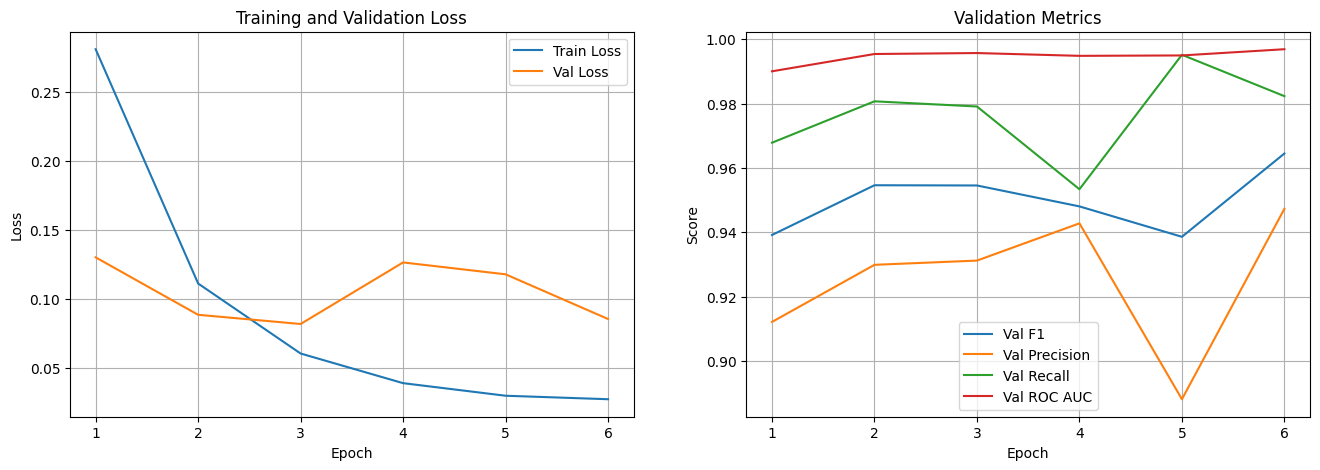

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# F1, Precision, Recall
plt.subplot(1,2,2)
plt.plot(epochs, val_f1s, label="Val F1")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.plot(epochs, val_roc_aucs, label="Val ROC AUC")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.legend()
plt.grid(True)

plt.show()

## Evaluation

Final test metrics: {'accuracy': 0.9678111587982833, 'precision': 0.9436123348017621, 'recall': 0.9762989972652689, 'f1': 0.9596774193548387, 'roc_auc': 0.9935556493899839}


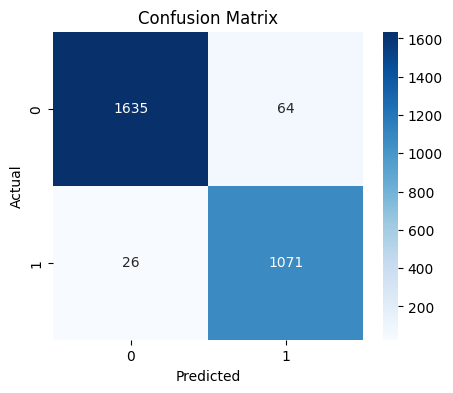

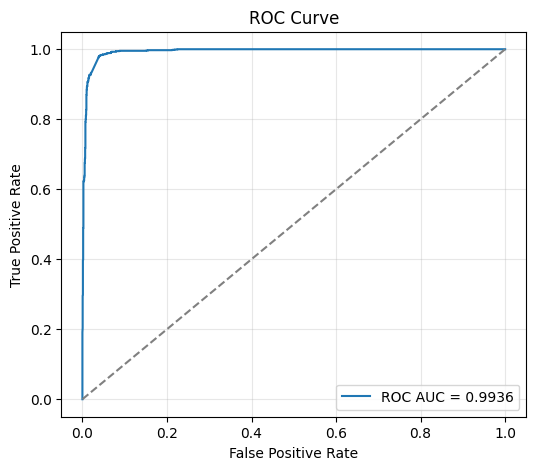

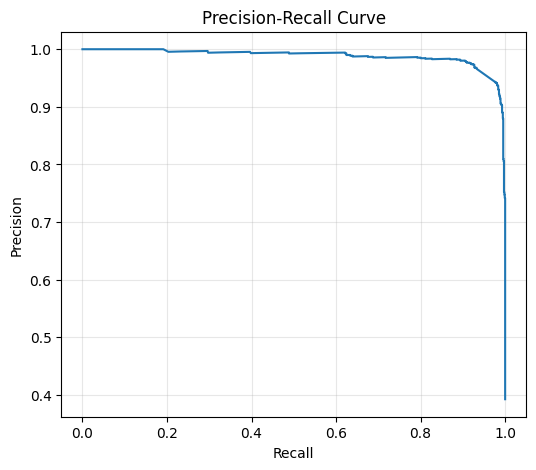

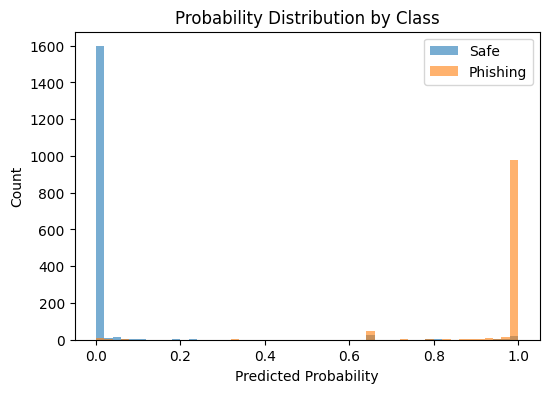

In [16]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix
)

# Load best model
ckpt = torch.load(WEIGHTS_FILE_PATH, map_location=DEVICE, weights_only=False)
model.load_state_dict(ckpt["model_state"])
scaler = ckpt["scaler"]
stoi = ckpt["stoi"]
itos = ckpt["itos"]

# Evaluate on test set
trues_test, probs_test, test_loss = eval_model(model, test_loader, criterion)
test_metrics = compute_metrics(trues_test, probs_test)
print("Final test metrics:", test_metrics)

# Confusion Matrix
cm = confusion_matrix(trues_test, (probs_test[:, 1] >= 0.5).astype(int))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(trues_test, probs_test[:, 1])
roc_auc = test_metrics["roc_auc"]
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(trues_test, probs_test[:, 1])
plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(alpha=0.3)
plt.show()

# Probability Distribution by Class
plt.figure(figsize=(6,4))
plt.hist(probs_test[trues_test==0, 1], bins=50, alpha=0.6, label="Safe")
plt.hist(probs_test[trues_test==1, 1], bins=50, alpha=0.6, label="Phishing")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Probability Distribution by Class")
plt.legend()
plt.show()


In [13]:
ckpt = torch.load(WEIGHTS_FILE_PATH, map_location=DEVICE, weights_only=False)
model.load_state_dict(ckpt["model_state"])
scaler = ckpt["scaler"]
stoi = ckpt["stoi"]
itos = ckpt["itos"]

trues_test, probs_test, test_loss = eval_model(model, test_loader, criterion)
test_metrics = compute_metrics(trues_test, probs_test)
print("Final test metrics:", test_metrics)

Final test metrics: {'accuracy': 0.9678111587982833, 'precision': 0.9436123348017621, 'recall': 0.9762989972652689, 'f1': 0.9596774193548387, 'roc_auc': 0.9935556493899839}


## Inference

In [ ]:
def load_artifacts(filepath="best_phish_model.pth"):
    ckpt = torch.load(filepath, map_location=DEVICE)
    model = PhishingDetectorModel(
        vocab_size=len(ckpt["stoi"]),
        emb_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_feats_dim=6,
    )
    model.load_state_dict(ckpt["model_state"])
    model.to(DEVICE)
    model.eval()
    return model, ckpt["stoi"], ckpt["scaler"]


def preprocess_single(body, stoi, scaler, max_len=MAX_LEN):
    text = preprocess_text(body)
    toks = tokenize(text)
    ids = [stoi.get(tok, stoi.get("<UNK>")) for tok in toks][:max_len]

    # numeric features
    n_upper = sum(1 for c in raw if c.isupper())
    n_exclaim = raw.count("!")
    n_special = sum(1 for c in raw if not c.isalnum() and not c.isspace())
    length = len(text.split())
    has_login_words = int(bool(KEYWORD_PATTERN.search(text)))
    feats = np.array(
        [[n_urls, n_upper, n_exclaim, n_special, length, has_login_words]],
        dtype=np.float32,
    )
    feats = scaler.transform(feats)

    seq = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    num = torch.tensor(feats, dtype=torch.float).to(DEVICE)
    return seq, lengths, num


def predict_email(body, model, stoi, scaler, threshold=0.5):
    seq, lengths, num = preprocess_single(body, stoi, scaler)
    with torch.no_grad():
        logits, attn = model(seq, lengths, num)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    label = int(probs[1] >= threshold)
    return {
        "prob_safe": float(probs[0]),
        "prob_phish": float(probs[1]),
        "label": label,
        "attn_weights": attn.cpu().numpy() if attn is not None else None,
    }